# Imports

In [25]:
# %pip install numpy
# %pip install pandas
# %pip install sklearn
# %pip install matplotlib
# %pip install tensorflow
import tensorflow.keras.utils as ku
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.metrics as kme
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from scipy.io import arff
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
import itertools as it
from matplotlib import pyplot as plt


pd.set_option('display.max_rows', 500)

# Load data

In [3]:
columns = ["net profit / total assets", "total liabilities / total assets", "working capital / total assets", "current assets / short-term liabilities", "[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365", "retained earnings / total assets", "EBIT / total assets", "book value of equity / total liabilities", "sales / total assets", "equity / total assets", "(gross profit + extraordinary items + financial expenses) / total assets", "gross profit / short-term liabilities", "(gross profit + depreciation) / sales", "(gross profit + interest) / total assets", "(total liabilities * 365) / (gross profit + depreciation)", "(gross profit + depreciation) / total liabilities", "total assets / total liabilities", "gross profit / total assets", "gross profit / sales", "(inventory * 365) / sales", "sales (n) / sales (n-1)", "profit on operating activities / total assets", "net profit / sales", "gross profit (in 3 years) / total assets", "(equity - share capital) / total assets", "(net profit + depreciation) / total liabilities", "profit on operating activities / financial expenses", "working capital / fixed assets", "logarithm of total assets", "(total liabilities - cash) / sales", "(gross profit + interest) / sales", "(current liabilities * 365) / cost of products sold", "operating expenses / short-term liabilities", "operating expenses / total liabilities", "profit on sales / total assets", "total sales / total assets", "(current assets - inventories) / long-term liabilities", "constant capital / total assets", "profit on sales / sales", "(current assets - inventory - receivables) / short-term liabilities", "total liabilities / ((profit on operating activities + depreciation) * (12/365))", "profit on operating activities / sales", "rotation receivables + inventory turnover in days", "(receivables * 365) / sales", "net profit / inventory", "(current assets - inventory) / short-term liabilities", "(inventory * 365) / cost of products sold", "EBITDA (profit on operating activities - depreciation) / total assets", "EBITDA (profit on operating activities - depreciation) / sales", "current assets / total liabilities", "short-term liabilities / total assets", "(short-term liabilities * 365) / cost of products sold)", "equity / fixed assets", "constant capital / fixed assets", "working capital", "(sales - cost of products sold) / sales", "(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)", "total costs /total sales", "long-term liabilities / equity", "sales / inventory", "sales / receivables", "(short-term liabilities *365) / sales", "sales / short-term liabilities", "sales / fixed assets", "IsGoingToBankrupt"]
data_1_year = arff.loadarff('datasets/1year.arff')
data_2_year = arff.loadarff('datasets/2year.arff')
data_3_year = arff.loadarff('datasets/3year.arff')
data_4_year = arff.loadarff('datasets/4year.arff')
data_5_year = arff.loadarff('datasets/5year.arff')

df_1_year = pd.DataFrame(data_1_year[0])
df_1_year.set_axis(columns, inplace=True, axis=1)
df_1_year['IsGoingToBankrupt'] = df_1_year.apply(lambda x: x[64] == b'1', axis=1)

df_2_year = pd.DataFrame(data_2_year[0])
df_2_year.set_axis(columns, inplace=True, axis=1)
df_2_year['IsGoingToBankrupt'] = df_2_year.apply(lambda x: x[64] == b'1', axis=1)

df_3_year = pd.DataFrame(data_3_year[0])
df_3_year.set_axis(columns, inplace=True, axis=1)
df_3_year['IsGoingToBankrupt'] = df_3_year.apply(lambda x: x[64] == b'1', axis=1)

df_4_year = pd.DataFrame(data_4_year[0])
df_4_year.set_axis(columns, inplace=True, axis=1)
df_4_year['IsGoingToBankrupt'] = df_4_year.apply(lambda x: x[64] == b'1', axis=1)

df_5_year = pd.DataFrame(data_5_year[0])
df_5_year.set_axis(columns, inplace=True, axis=1)
df_5_year['IsGoingToBankrupt'] = df_5_year.apply(lambda x: x[64] == b'1', axis=1)

# Choose columns

In [4]:
columns_left = ['net profit / total assets', 'total liabilities / total assets',
       'sales / total assets', 'sales (n) / sales (n-1)',
       'working capital / fixed assets', 'sales / fixed assets',
       'IsGoingToBankrupt']
df_1_year = df_1_year[columns_left]
df_2_year = df_2_year[columns_left]
df_3_year = df_3_year[columns_left]
df_4_year = df_4_year[columns_left]
df_5_year = df_5_year[columns_left]

# Drop null values

In [5]:
df_1_year.dropna(inplace=True)
df_2_year.dropna(inplace=True)
df_3_year.dropna(inplace=True)
df_4_year.dropna(inplace=True)
df_5_year.dropna(inplace=True)

# Calculate covariance matrix

In [6]:
def calc_corr(data_frame):
    columns = data_frame.columns
    results = pd.DataFrame(columns=columns, index=columns)
    for column1 in columns:
        for column2 in columns:
            if column1 == column2:
                continue
            corr, _ = spearmanr(data_frame[column1], data_frame[column2])
            results[column1][column2] = corr
    return results

def eliminate_high_corr_columns(data_frame_corr_mat, eps = 0.9, verbose = True):
    columns = data_frame_corr_mat.columns
    column1 = 0
    while column1 < len(columns):
        to_drop = []
        for column2 in range(column1 + 1, len(columns)):
            if column1 == column2:
                continue
            corr = data_frame_corr_mat[columns[column1]][columns[column2]]
            if abs(corr) > eps:
                if verbose:
                    print(f'Corr: {corr}, DELETING {columns[column2]}')
                to_drop.append(columns[column2])
        columns = columns.drop(to_drop)
        column1 += 1
    return columns

In [7]:
# columns_after_drop = eliminate_high_corr_columns(calc_corr(df_1_year), 0.5, verbose=False)
# columns_after_drop = columns_after_drop.drop(['(inventory * 365) / sales' ,
                                                # '(current assets - inventory - receivables) / short-term liabilities',
                                                #  '(current assets - inventories) / long-term liabilities',
                                                #  '(current liabilities * 365) / cost of products sold',
                                                #  '(receivables * 365) / sales',
                                                #  'logarithm of total assets',
                                                #  'retained earnings / total assets'])
display(calc_corr(df_1_year))
display(len(calc_corr(df_1_year)))

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets,IsGoingToBankrupt
net profit / total assets,NaN,-0.345923,0.37288,0.248321,0.397886,0.247716,-0.105604
total liabilities / total assets,-0.345923,NaN,0.052886,0.089429,-0.435515,0.173057,0.081187
sales / total assets,0.37288,0.052886,NaN,0.086063,0.224087,0.476363,-0.074266
sales (n) / sales (n-1),0.248321,0.089429,0.086063,NaN,0.010606,0.08178,-0.038732
working capital / fixed assets,0.397886,-0.435515,0.224087,0.010606,NaN,0.520471,-0.087244
sales / fixed assets,0.247716,0.173057,0.476363,0.08178,0.520471,NaN,-0.020321
IsGoingToBankrupt,-0.105604,0.081187,-0.074266,-0.038732,-0.087244,-0.020321,NaN


7

# Separate bankrupt and non-bankrupt

In [8]:
year_1_b = df_1_year.query('IsGoingToBankrupt == True').drop(columns=['IsGoingToBankrupt'])
year_1_nb = df_1_year.query('IsGoingToBankrupt == False').drop(columns=['IsGoingToBankrupt'])

year_1_b = year_1_b.reset_index().drop(columns=['index'])
year_1_nb = year_1_nb.reset_index().drop(columns=['index'])


year_2_b = df_2_year.query('IsGoingToBankrupt == True').drop(columns=['IsGoingToBankrupt'])
year_2_nb = df_2_year.query('IsGoingToBankrupt == False').drop(columns=['IsGoingToBankrupt'])

year_2_b = year_2_b.reset_index().drop(columns=['index'])
year_2_nb = year_2_nb.reset_index().drop(columns=['index'])


year_3_b = df_3_year.query('IsGoingToBankrupt == True').drop(columns=['IsGoingToBankrupt'])
year_3_nb = df_3_year.query('IsGoingToBankrupt == False').drop(columns=['IsGoingToBankrupt'])

year_3_b = year_3_b.reset_index().drop(columns=['index'])
year_3_nb = year_3_nb.reset_index().drop(columns=['index'])


year_4_b = df_4_year.query('IsGoingToBankrupt == True').drop(columns=['IsGoingToBankrupt'])
year_4_nb = df_4_year.query('IsGoingToBankrupt == False').drop(columns=['IsGoingToBankrupt'])

year_4_b = year_4_b.reset_index().drop(columns=['index'])
year_4_nb = year_4_nb.reset_index().drop(columns=['index'])


year_5_b = df_5_year.query('IsGoingToBankrupt == True').drop(columns=['IsGoingToBankrupt'])
year_5_nb = df_5_year.query('IsGoingToBankrupt == False').drop(columns=['IsGoingToBankrupt'])

year_5_b = year_5_b.reset_index().drop(columns=['index'])
year_5_nb = year_5_nb.reset_index().drop(columns=['index'])

In [9]:
print(f'In 1 year\n Num of bankrupt: {len(year_1_b)}\tNum of non-bankrupt: {len(year_1_nb)}')
print(f'In 2 year\n Num of bankrupt: {len(year_2_b)}\tNum of non-bankrupt: {len(year_2_nb)}')
print(f'In 3 year\n Num of bankrupt: {len(year_3_b)}\tNum of non-bankrupt: {len(year_3_nb)}')
print(f'In 4 year\n Num of bankrupt: {len(year_4_b)}\tNum of non-bankrupt: {len(year_4_nb)}')
print(f'In 5 year\n Num of bankrupt: {len(year_5_b)}\tNum of non-bankrupt: {len(year_5_nb)}')

In 1 year
 Num of bankrupt: 159	Num of non-bankrupt: 5223
In 2 year
 Num of bankrupt: 243	Num of non-bankrupt: 6747
In 3 year
 Num of bankrupt: 344	Num of non-bankrupt: 9157
In 4 year
 Num of bankrupt: 385	Num of non-bankrupt: 9033
In 5 year
 Num of bankrupt: 301	Num of non-bankrupt: 5408


# Outliers

In [10]:
def find_outliers(data_frame):
    clf = LocalOutlierFactor(n_neighbors=3)
    outliers = clf.fit_predict(data_frame)
    outliers_indexes = np.where(outliers == - 1)[0]
    rest_indexes = np.where(outliers == 1)[0]
    outliers = data_frame.loc[outliers_indexes]
    df_without_outliers = data_frame.loc[rest_indexes]
    df_without_outliers = df_without_outliers.reset_index().drop(columns=['index'])
    return outliers, df_without_outliers

In [11]:
outliers_year_1_b, year_1_b_clean = find_outliers(year_1_b)
outliers_year_1_nb, year_1_nb_clean = find_outliers(year_1_nb)

In [12]:
display(year_1_b_clean.describe())
display(year_1_nb_clean.describe())

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,0.041344,0.631580,1.380882,1.133796,0.784254,11.279705
std,0.160158,0.313066,0.930295,0.306808,3.365460,27.962758
min,-0.378420,0.072135,0.280070,0.236800,-2.628200,0.102810
25%,0.000493,0.441220,1.004000,0.986870,-0.159820,2.074300
50%,0.023532,0.598550,1.039500,1.125500,0.066187,4.223000
75%,0.101230,0.797560,1.213200,1.256600,0.372580,8.495200
max,1.138800,1.980200,5.695800,2.636800,31.990000,215.220000


,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000
mean,0.101957,0.461865,3.117337,1.234313,1.764811,49.657128
std,0.135392,1.065024,58.565398,0.860404,10.945045,1115.205407
min,-0.531970,-72.162000,0.002692,0.000405,-123.030000,0.000162
25%,0.024807,0.293605,1.034900,1.029900,0.072396,2.506150
50%,0.076327,0.464350,1.149300,1.138400,0.463890,4.421900
75%,0.150195,0.649525,1.903500,1.284650,1.258900,8.833400
max,1.938000,2.063200,3668.300000,24.093000,492.350000,44785.000000


In [13]:
display(year_1_b_clean.describe())
display(outliers_year_1_b)

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,0.041344,0.631580,1.380882,1.133796,0.784254,11.279705
std,0.160158,0.313066,0.930295,0.306808,3.365460,27.962758
min,-0.378420,0.072135,0.280070,0.236800,-2.628200,0.102810
25%,0.000493,0.441220,1.004000,0.986870,-0.159820,2.074300
50%,0.023532,0.598550,1.039500,1.125500,0.066187,4.223000
75%,0.101230,0.797560,1.213200,1.256600,0.372580,8.495200
max,1.138800,1.980200,5.695800,2.636800,31.990000,215.220000


,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
7,-1.125800,0.727620,0.095267,0.37993,-0.337310,0.17792
8,0.021227,0.378230,1.638900,1.01130,0.069663,2.81940
11,0.061977,0.333040,1.559900,0.97972,0.981260,4.38930
15,-0.075637,0.197880,1.155400,1.26510,0.442800,2.04380
24,0.005924,0.908900,0.820830,0.45087,8.559200,84.08200
33,0.595310,0.044336,0.618420,0.93216,0.051813,0.14166
42,0.024111,0.727850,1.018000,3.38490,-0.207570,6.07620
44,-0.120720,0.966750,0.939680,0.99876,-0.894120,4.98740
50,-0.030098,1.472400,1.250200,0.79641,1.051000,0.16014
57,-0.074176,0.581120,7.424100,1.05060,0.239610,21.97100


In [14]:
display(year_1_nb_clean.describe())
display(outliers_year_1_nb)

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000
mean,0.101957,0.461865,3.117337,1.234313,1.764811,49.657128
std,0.135392,1.065024,58.565398,0.860404,10.945045,1115.205407
min,-0.531970,-72.162000,0.002692,0.000405,-123.030000,0.000162
25%,0.024807,0.293605,1.034900,1.029900,0.072396,2.506150
50%,0.076327,0.464350,1.149300,1.138400,0.463890,4.421900
75%,0.150195,0.649525,1.903500,1.284650,1.258900,8.833400
max,1.938000,2.063200,3668.300000,24.093000,492.350000,44785.000000


,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
46,0.148130,0.504480,1.087600,0.53504,1.544100,7.270500
64,0.121460,0.240690,1.115800,0.58355,0.408620,2.980500
80,0.908560,0.548690,3.351700,1.00450,-0.002073,6.148500
83,-0.030391,1.501500,0.987450,1.52370,-1.797800,11.635000
94,0.218470,0.243950,1.519000,1.24620,19.221000,40.626000
111,0.255460,0.377770,2.355100,1.79440,0.580300,5.416700
118,0.096341,1.575500,1.916600,0.91227,-5.226200,18.588000
133,-0.008594,0.624040,1.052600,0.37556,1.235700,3.859500
150,0.010412,0.688440,1.874700,2.71730,0.653110,7.123800
176,-0.013109,0.893860,0.940110,2.47980,-0.582830,6.182100


# Clusterization - dbscan

In [15]:
def clusterize(data_frame, eps):
    normalized_df=(data_frame-data_frame.min())/(data_frame.max()-data_frame.min())
    clustering = DBSCAN(eps=eps).fit(normalized_df)
    output = []
    for label in range(clustering.n_features_in_):
        tmp_indexes = np.where(clustering.labels_ == label)[0]
        tmp = data_frame.loc[tmp_indexes].reset_index().drop(columns=['index'])
        output.append(tmp)
    return output

def display_clusters(clusters):
    for i, cluster in enumerate(clusters):
        if(len(cluster)):
            display(f'Cluster {i}:')
            display(f'Number of elements: {len(cluster)}')
            display(cluster.describe())

In [16]:
display(year_1_b_clean.describe())
clusters = clusterize(year_1_b_clean, 0.1)
display_clusters(clusters)

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,0.041344,0.631580,1.380882,1.133796,0.784254,11.279705
std,0.160158,0.313066,0.930295,0.306808,3.365460,27.962758
min,-0.378420,0.072135,0.280070,0.236800,-2.628200,0.102810
25%,0.000493,0.441220,1.004000,0.986870,-0.159820,2.074300
50%,0.023532,0.598550,1.039500,1.125500,0.066187,4.223000
75%,0.101230,0.797560,1.213200,1.256600,0.372580,8.495200
max,1.138800,1.980200,5.695800,2.636800,31.990000,215.220000


'Cluster 0:'

'Number of elements: 75'

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,0.034482,0.581582,1.062879,1.101000,0.114672,4.805544
std,0.068055,0.195580,0.126344,0.164836,0.418234,4.241221
min,-0.142120,0.122390,0.755520,0.807270,-0.671900,0.440570
25%,0.003008,0.458555,1.015750,0.985635,-0.090985,2.324100
50%,0.022707,0.556480,1.037900,1.099200,0.063800,3.625000
75%,0.051854,0.749550,1.081100,1.230050,0.219095,5.750300
max,0.274000,0.968490,1.787800,1.510100,1.729300,22.781000


'Cluster 1:'

'Number of elements: 5'

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000
mean,0.016504,0.735184,2.088160,1.188900,0.006727,5.81278
std,0.009830,0.091087,0.135724,0.123497,0.322844,2.74724
min,0.006404,0.617610,1.910900,1.086200,-0.334410,3.12880
25%,0.009313,0.674770,2.027300,1.096100,-0.278960,4.97920
50%,0.013551,0.758250,2.080200,1.178600,-0.022504,5.09650
75%,0.023532,0.772760,2.147100,1.190400,0.296930,5.39840
max,0.029722,0.852530,2.275300,1.393200,0.372580,10.46100


In [17]:
display(year_1_nb_clean.describe())
clusters = clusterize(year_1_nb_clean, 0.01)
display_clusters(clusters)

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000
mean,0.101957,0.461865,3.117337,1.234313,1.764811,49.657128
std,0.135392,1.065024,58.565398,0.860404,10.945045,1115.205407
min,-0.531970,-72.162000,0.002692,0.000405,-123.030000,0.000162
25%,0.024807,0.293605,1.034900,1.029900,0.072396,2.506150
50%,0.076327,0.464350,1.149300,1.138400,0.463890,4.421900
75%,0.150195,0.649525,1.903500,1.284650,1.258900,8.833400
max,1.938000,2.063200,3668.300000,24.093000,492.350000,44785.000000


'Cluster 0:'

'Number of elements: 4650'

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,4650.000000,4650.000000,4650.000000,4650.000000,4650.000000,4650.000000
mean,0.095838,0.473319,1.608404,1.173214,1.017630,8.792655
std,0.104192,0.231720,1.050994,0.239040,1.946469,17.249061
min,-0.213610,0.004765,0.049636,0.236800,-3.960200,0.054670
25%,0.025565,0.294905,1.035225,1.029850,0.072860,2.475375
50%,0.075704,0.463340,1.143600,1.136100,0.443420,4.307050
75%,0.145165,0.644053,1.839500,1.274800,1.159750,8.180050
max,0.505830,1.507000,14.171000,2.469800,18.223000,307.590000


'Cluster 1:'

'Number of elements: 4'

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,-0.227767,0.771725,2.853075,0.978123,-0.235850,9.805300
std,0.009416,0.318621,3.844429,0.120237,0.911241,6.380191
min,-0.240710,0.478560,0.918840,0.849780,-1.441000,3.863900
25%,-0.230502,0.539010,0.927975,0.892478,-0.662200,4.750700
50%,-0.226050,0.716420,0.936880,0.977155,-0.069680,9.170650
75%,-0.223315,0.949135,2.861980,1.062800,0.356670,14.225250
max,-0.218260,1.175500,8.619700,1.108400,0.636960,17.016000


'Cluster 2:'

'Number of elements: 3'

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.032995,0.611867,2.376333,1.036833,14.545333,175.586000
std,0.005850,0.124644,1.455971,0.160027,0.634957,90.473371
min,0.027241,0.530140,1.008800,0.866800,13.816000,71.638000
25%,0.030024,0.540135,1.611000,0.963000,14.330500,145.084000
50%,0.032807,0.550130,2.213200,1.059200,14.845000,218.530000
75%,0.035872,0.652730,3.060100,1.121850,14.910000,227.560000
max,0.038937,0.755330,3.907000,1.184500,14.975000,236.590000


'Cluster 3:'

'Number of elements: 5'

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.570566,0.187262,3.254220,1.140122,1.306964,9.116760
std,0.009933,0.134034,1.995132,0.096363,0.686566,5.205773
min,0.558700,0.061021,1.624100,0.985710,0.515440,3.721800
25%,0.561670,0.066357,1.768900,1.130300,0.735080,5.265300
50%,0.573710,0.154290,2.611700,1.145900,1.356300,7.784700
75%,0.577180,0.305120,3.794400,1.201800,1.782200,12.571000
max,0.581570,0.349520,6.472000,1.236900,2.145800,16.241000


# Clusterization - kmeans

In [18]:
def clusterize_kmeans(data_frame, cluster_am):
    normalized_df=(data_frame-data_frame.min())/(data_frame.max()-data_frame.min())
    clustering = KMeans(n_clusters=cluster_am).fit(normalized_df)
    output = []
    for label in range(clustering.n_features_in_):
        tmp_indexes = np.where(clustering.labels_ == label)[0]
        tmp = data_frame.loc[tmp_indexes].reset_index().drop(columns=['index'])
        output.append(tmp)
    return output


In [19]:
display(year_1_b_clean.describe())
clusters = clusterize_kmeans(year_1_b_clean, 4)
display_clusters(clusters)

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,0.041344,0.631580,1.380882,1.133796,0.784254,11.279705
std,0.160158,0.313066,0.930295,0.306808,3.365460,27.962758
min,-0.378420,0.072135,0.280070,0.236800,-2.628200,0.102810
25%,0.000493,0.441220,1.004000,0.986870,-0.159820,2.074300
50%,0.023532,0.598550,1.039500,1.125500,0.066187,4.223000
75%,0.101230,0.797560,1.213200,1.256600,0.372580,8.495200
max,1.138800,1.980200,5.695800,2.636800,31.990000,215.220000


'Cluster 0:'

'Number of elements: 14'

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,0.140129,0.615896,3.702443,1.217415,1.409054,17.916114
std,0.149375,0.300917,1.134196,0.216298,1.866224,11.274820
min,-0.009092,0.237270,2.377500,0.955310,-1.404100,5.389300
25%,0.027275,0.432295,2.700375,1.032300,0.078047,8.517525
50%,0.109755,0.578090,3.477300,1.173550,1.115300,14.480500
75%,0.183195,0.797080,4.726225,1.388875,2.891150,24.333250
max,0.561820,1.308900,5.695800,1.570600,4.673300,39.441000


'Cluster 1:'

'Number of elements: 34'

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,0.001110,0.957472,1.158245,1.360421,-0.377571,6.831721
std,0.127647,0.330421,0.400824,0.371471,0.970039,6.067889
min,-0.378420,0.650620,0.740000,0.692900,-2.628200,0.980230
25%,-0.030716,0.776887,1.005250,1.164350,-0.497918,1.992925
50%,0.022566,0.853195,1.026250,1.259000,-0.232935,4.617100
75%,0.061382,0.926393,1.070125,1.421925,0.059042,9.291725
max,0.254870,1.980200,2.275300,2.636800,2.399300,22.781000


'Cluster 2:'

'Number of elements: 4'

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,0.342919,0.790168,1.084975,1.045180,11.844725,159.060000
std,0.532544,0.160125,0.149591,0.224473,13.913410,44.849872
min,0.013828,0.568260,0.974300,0.740120,1.316600,114.340000
25%,0.079379,0.748387,1.002800,0.975755,3.366875,128.447500
50%,0.109525,0.821470,1.030450,1.081550,7.036150,153.340000
75%,0.373065,0.863250,1.112625,1.150975,15.514000,183.952500
max,1.138800,0.949470,1.304700,1.277500,31.990000,215.220000


'Cluster 3:'

'Number of elements: 81'

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,0.026266,0.489665,1.087690,1.028593,0.617747,4.701934
std,0.119030,0.184866,0.310111,0.232924,1.920467,5.197099
min,-0.374490,0.072135,0.280070,0.236800,-0.876270,0.102810
25%,-0.000153,0.364450,0.996600,0.913130,-0.098463,1.680300
50%,0.019432,0.508000,1.038500,1.059500,0.118760,3.128800
75%,0.080700,0.616330,1.105200,1.171700,0.323870,5.148900
max,0.467360,0.932660,2.099800,1.637800,10.875000,25.744000


In [20]:
display(year_1_nb_clean.describe())
clusters = clusterize_kmeans(year_1_nb_clean, 4)
display_clusters(clusters)

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000,4911.000000
mean,0.101957,0.461865,3.117337,1.234313,1.764811,49.657128
std,0.135392,1.065024,58.565398,0.860404,10.945045,1115.205407
min,-0.531970,-72.162000,0.002692,0.000405,-123.030000,0.000162
25%,0.024807,0.293605,1.034900,1.029900,0.072396,2.506150
50%,0.076327,0.464350,1.149300,1.138400,0.463890,4.421900
75%,0.150195,0.649525,1.903500,1.284650,1.258900,8.833400
max,1.938000,2.063200,3668.300000,24.093000,492.350000,44785.000000


'Cluster 0:'

'Number of elements: 911'

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000
mean,0.307360,0.355241,2.094245,1.297204,4.111463,24.239581
std,0.155403,0.193129,1.382255,0.378191,20.563532,102.116665
min,0.176380,0.013253,0.261460,0.235030,-7.623500,0.261960
25%,0.215820,0.207895,1.172900,1.105050,0.491240,3.976100
50%,0.259830,0.334110,1.562100,1.232500,1.164200,6.785600
75%,0.346540,0.478285,2.608650,1.408750,2.673350,14.563500
max,1.938000,1.413700,11.670000,7.024300,492.350000,2214.300000


'Cluster 1:'

'Number of elements: 18'

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,0.012951,0.466861,1.029428,13.210978,0.355030,2.819168
std,0.094778,0.295403,0.250341,5.387487,0.613368,2.787387
min,-0.193680,0.081020,0.468490,8.459300,-0.710930,0.534540
25%,-0.022511,0.247185,0.988450,9.266625,0.012741,1.102513
50%,0.005050,0.389510,1.039900,10.809000,0.129415,1.868950
75%,0.072724,0.818337,1.078025,16.492000,0.807388,2.947975
max,0.181860,0.870230,1.741600,24.093000,1.733600,10.455000


'Cluster 2:'

'Number of elements: 3977'

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,3977.000000,3977.000000,3977.000000,3977.000000,3977.000000,3977.000000
mean,0.055436,0.505601,1.546518,1.165759,1.235870,12.920582
std,0.072048,0.241935,1.022061,0.319858,7.042554,71.281398
min,-0.531970,0.004765,0.002692,0.000405,-123.030000,0.000162
25%,0.016563,0.325480,1.023800,1.017400,0.034350,2.299400
50%,0.057300,0.502330,1.104800,1.119300,0.350680,4.023500
75%,0.103910,0.677820,1.744400,1.256200,0.983010,7.702300
max,0.183660,2.063200,14.171000,6.914500,266.600000,2391.000000


'Cluster 3:'

'Number of elements: 5'

,net profit / total assets,total liabilities / total assets,sales / total assets,sales (n) / sales (n-1),working capital / fixed assets,sales / fixed assets
count,5.0,5.00000,5.00000,5.000000,5.0,5.000000
mean,0.0,-14.91676,1446.47000,1.187336,0.0,34069.600000
std,0.0,32.01824,1265.67814,0.250558,0.0,8426.365011
min,0.0,-72.16200,550.31000,0.932980,0.0,23183.000000
25%,0.0,-2.42180,774.14000,1.059400,0.0,31024.000000
50%,0.0,0.00000,1083.20000,1.143200,0.0,31422.000000
75%,0.0,0.00000,1156.40000,1.204100,0.0,39934.000000
max,0.0,0.00000,3668.30000,1.597000,0.0,44785.000000


# Graphs - relations between atributes

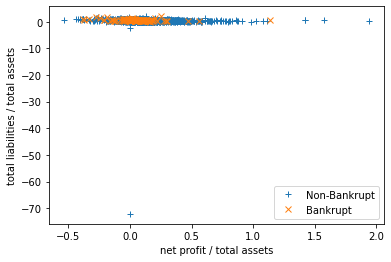

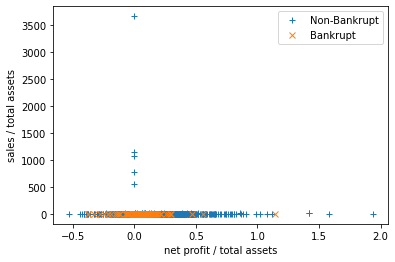

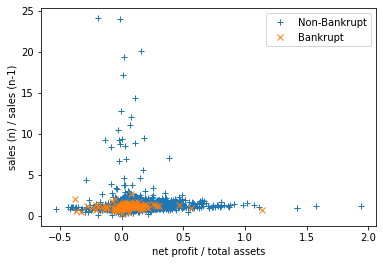

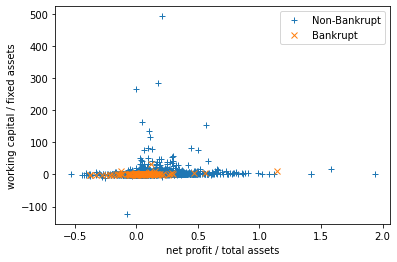

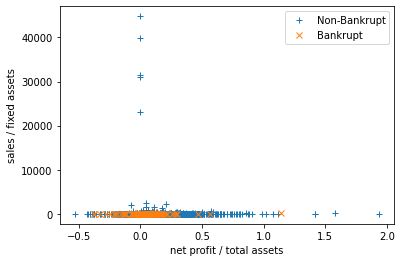

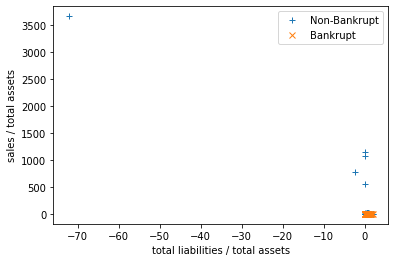

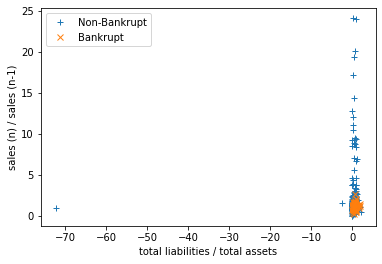

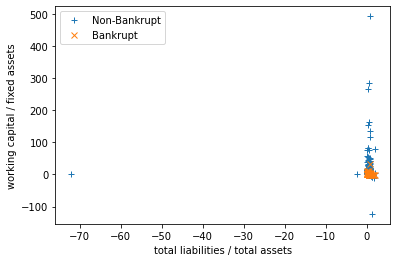

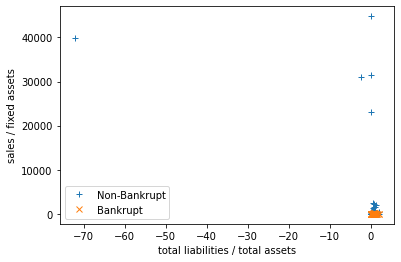

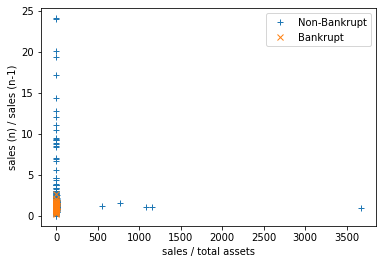

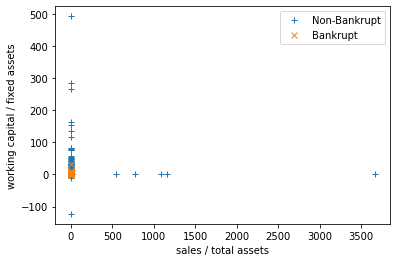

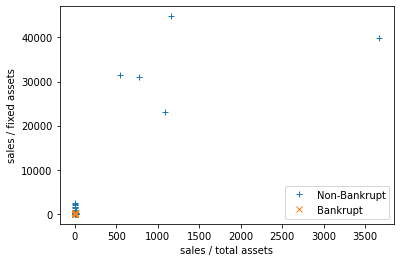

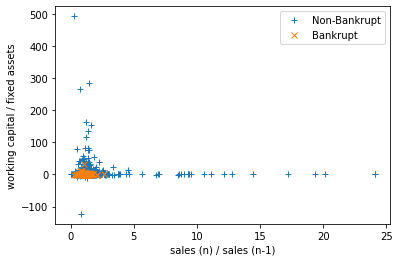

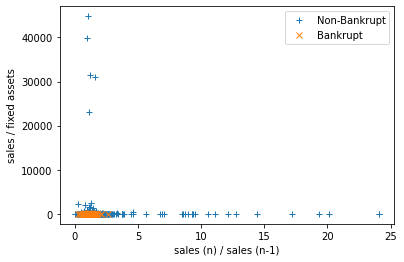

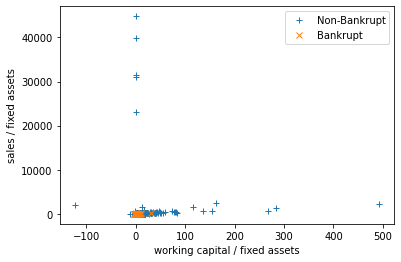

In [21]:
for A, B in it.combinations(year_1_b_clean.columns, 2):
    plt.xlabel(A)
    plt.ylabel(B)
    plt.plot(year_1_nb_clean[A], year_1_nb_clean[B], '+', label="Non-Bankrupt")
    plt.plot(year_1_b_clean[A], year_1_b_clean[B], 'x', label="Bankrupt")
    plt.legend()
    plt.show()

# Classification

## Data preparation

In [51]:
def get_data(d = [
        (year_1_b, year_1_nb),
        (year_2_b, year_2_nb),
        (year_3_b, year_3_nb),
        (year_4_b, year_4_nb),
        (year_5_b, year_5_nb),
    ]):
    model_data = pd.DataFrame(columns=df_1_year.columns)
    for pair in d:
        _, b_clean = find_outliers(pair[0])
        b_clean['IsGoingToBankrupt'] = 1
        _, nb_clean = find_outliers(pair[1])
        nb_clean['IsGoingToBankrupt'] = 0
        model_data = model_data.append(b_clean).append(nb_clean.sample(n=len(b_clean)))

    model_data = model_data.sample(frac=1)
    model_data = model_data.reset_index().drop(columns=['index'])
    return model_data
model_data = get_data()
model_data['IsGoingToBankrupt'].value_counts()

0    1273
1    1273
Name: IsGoingToBankrupt, dtype: int64

## Model

In [23]:
def rand_metric(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return (tp + tn)/(tp + tn + fp + fn)

def get_model(input_size):
    model = km.Sequential()
    model.add(kl.Dense(12, input_dim=input_size, activation='relu'))
    model.add(kl.Dense(6, input_dim=input_size, activation='relu'))
    model.add(kl.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', rand_metric])
    return model

def split_data(X, Y, perc=(0.8,0.1,0.1)):
    X_train, X_validate, X_test = np.split(X,[int(X.shape[0] * perc[0]), int(X.shape[0] * (perc[0] + perc[1]))])
    Y_train, Y_validate, Y_test = np.split(Y,[int(Y.shape[0] * perc[0]), int(Y.shape[0] * (perc[0] + perc[1]))])
    return X_train, X_validate, X_test, Y_train, Y_validate, Y_test

def get_trained_model(model_data):
    X, Y = model_data.drop('IsGoingToBankrupt', axis=1).to_numpy().astype(np.float32), model_data['IsGoingToBankrupt'].to_numpy().astype(np.int32)
    X_train, X_validate, X_test, Y_train, Y_validate, Y_test = split_data(X, Y)
    model = get_model(X_train.shape[1])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, verbose=1, batch_size=10)
    return model, history
model, history = get_trained_model(model_data)

Epoch 1/50
204/204 [==============================] - 2s 2ms/step - loss: 1.0609 - accuracy: 0.5496 - rand_metric: 0.5498 - val_loss: 0.7681 - val_accuracy: 0.6549 - val_rand_metric: 0.6577
Epoch 2/50
204/204 [==============================] - 0s 1ms/step - loss: 0.7664 - accuracy: 0.5820 - rand_metric: 0.5819 - val_loss: 0.7074 - val_accuracy: 0.6902 - val_rand_metric: 0.6885
Epoch 3/50
204/204 [==============================] - 0s 1ms/step - loss: 0.7150 - accuracy: 0.6002 - rand_metric: 0.6007 - val_loss: 0.6710 - val_accuracy: 0.6941 - val_rand_metric: 0.6962
Epoch 4/50
204/204 [==============================] - 0s 1ms/step - loss: 0.6895 - accuracy: 0.6390 - rand_metric: 0.6391 - val_loss: 0.6807 - val_accuracy: 0.6588 - val_rand_metric: 0.6577
Epoch 5/50
204/204 [==============================] - 0s 1ms/step - loss: 0.6720 - accuracy: 0.6365 - rand_metric: 0.6369 - val_loss: 0.6439 - val_accuracy: 0.6902 - val_rand_metric: 0.6885
Epoch 6/50
204/204 [==============================

In [83]:
def analyse(model, history, verbose=False):
    _, train_acc, train_rand_metric = model.evaluate(X_train, Y_train, verbose=0)
    _, test_acc, test_rand_metric = model.evaluate(X_test, Y_test, verbose=0)
#     if verbose:
#         print('Accuracy: Train: %.3f, Test: %.3f' % (train_acc, test_acc))
#         print('Rand:     Train: %.3f, Test: %.3f' % (train_rand_metric, test_rand_metric))

#         plt.plot(history.history['accuracy'], label="train")
#         plt.plot(history.history['val_accuracy'], label="validate")
#         plt.legend()
#         plt.show()

#         plt.plot(history.history['rand_metric'], label="train")
#         plt.plot(history.history['val_rand_metric'], label="validate")
#         plt.legend()
#         plt.show()
    return train_acc, test_acc, train_rand_metric, test_rand_metric

In [57]:
models_for_analysis = [get_trained_model(get_data()) for _ in range(10)]

Epoch 1/50
204/204 [==============================] - 1s 2ms/step - loss: 0.8582 - accuracy: 0.5417 - rand_metric: 0.5420 - val_loss: 0.7549 - val_accuracy: 0.5255 - val_rand_metric: 0.5192
Epoch 2/50
204/204 [==============================] - 0s 1ms/step - loss: 0.7514 - accuracy: 0.5388 - rand_metric: 0.5387 - val_loss: 0.7574 - val_accuracy: 0.5333 - val_rand_metric: 0.5269
Epoch 3/50
204/204 [==============================] - 0s 1ms/step - loss: 0.7019 - accuracy: 0.5540 - rand_metric: 0.5542 - val_loss: 0.6778 - val_accuracy: 0.6078 - val_rand_metric: 0.6000
Epoch 4/50
204/204 [==============================] - 0s 2ms/step - loss: 0.6964 - accuracy: 0.6277 - rand_metric: 0.6271 - val_loss: 0.7414 - val_accuracy: 0.6196 - val_rand_metric: 0.6154
Epoch 5/50
204/204 [==============================] - 0s 1ms/step - loss: 0.6697 - accuracy: 0.6434 - rand_metric: 0.6441 - val_loss: 0.6686 - val_accuracy: 0.6196 - val_rand_metric: 0.6115
Epoch 6/50
204/204 [==============================

In [85]:
data = []
is_verbose = True
for model, history in models_for_analysis:
    data.append(analyse(model, history, is_verbose))
    is_verbose = False
data = np.array(data)
means = data.mean(axis=0)
print("Train accuracy:    %.5f" % means[0])
print("Validate accuracy: %.5f" % means[1])
print("Train Rand:        %.5f" % means[2])
print("Validate Rand:     %.5f" % means[3])

Train accuracy:    0.67647
Validate accuracy: 0.70667
Train Rand:        0.67591
Validate Rand:     0.70699


[51, 0.7098039215686275]


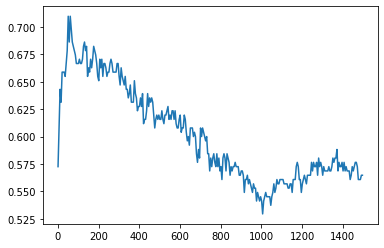

In [52]:
def knn_classification(X_train, Y_train, X_test, Y_test, k=5):
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean') 
    knn.fit(X_train, np.ravel(Y_train))
    Y_pred = knn.predict(X_test)
    return knn, metrics.accuracy_score(Y_test, Y_pred)

X, Y = model_data.drop('IsGoingToBankrupt', axis=1).to_numpy().astype(np.float32), model_data['IsGoingToBankrupt'].to_numpy().astype(np.int32)
X_train, X_validate, X_test, Y_train, Y_validate, Y_test = split_data(X, Y)

max_k = [0, 0]
plot_data = ([],[])
for k in range(1, 1500, 5):
    knn, acc = knn_classification(X_train, Y_train, X_test, Y_test, k)
    plot_data[0].append(k)
    plot_data[1].append(acc)
    if acc > max_k[1]:
        max_k = [k, acc]
        
print(max_k) 
plt.plot(*plot_data)
plt.show()